<a href="https://colab.research.google.com/github/dispectra/ekf-simulation/blob/main/Extended_Kalman_Filter_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Extended Kalman Filter Simulation**
</br>

---
This notebook is created by Dimas Apeco Putra (github.com/dispectra).
Major part of this notebook refers to [this source](https://github.com/AtsushiSakai/PythonRobotics/tree/master/Localization/extended_kalman_filter).

### Utilities Library

In [1]:
# Import Utilities Library
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot

### Simulation Parameter

In [2]:
#  Simulation parameter
DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

show_live_plot = False

#### Covariance matrices

$Q$ is covariance matrix of process noise, 

$R$ is covariance matrix of observation noise at time $t$ 

In [3]:
# Q : covariance matrix of process noise
Q = np.diag([
             0.1,  # variance of location on x-axis
             0.1,  # variance of location on y-axis
             np.deg2rad(1.0),  # variance of yaw angle
             1.0  # variance of velocity
             ]) ** 2

# R : covariance matrix of observation noise at time  t
R = np.diag([
             1.0,   # variance of x position observation
             1.0    # variance of y position observation
             ]) ** 2

#### Noises

In [4]:
INPUT_NOISE = np.diag([
                       1.0,
                       np.deg2rad(30.0)
                       ]) ** 2
GPS_NOISE = np.diag([0.5, 0.5]) ** 2

### Simulation Input

In [5]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v], [yawrate]])
    return u

In [6]:
def observation(xTrue, xd, u):
    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)

    # add noise to input
    ud = u + INPUT_NOISE @ np.random.randn(2, 1)

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

### Motion Model

The robot model is 

$$ \dot{x} = vcos(\phi)$$

$$ \dot{y} = vsin((\phi)$$

$$ \dot{\phi} = \omega$$


So, the motion model is

$$\textbf{x}_{t+1} = A\textbf{x}_t+B\textbf{u}_t$$

where

$\begin{equation*}
A=
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
B=
\begin{bmatrix}
cos(\phi)dt & 0\\
sin(\phi)dt & 0\\
0 & dt\\
1 & 0\\
\end{bmatrix}
\end{equation*}$

$dt$ is a time interval.

In [7]:
def motion_model(x, u):
    A = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = A @ x + B @ u

    return x

Jacobian matrix of $A$ is

$\begin{equation*}
J_A=
\begin{bmatrix}
\frac{dx}{dx}& \frac{dx}{dy} & \frac{dx}{d\phi} &  \frac{dx}{dv}\\
\frac{dy}{dx}& \frac{dy}{dy} & \frac{dy}{d\phi} &  \frac{dy}{dv}\\
\frac{d\phi}{dx}& \frac{d\phi}{dy} & \frac{d\phi}{d\phi} &  \frac{d\phi}{dv}\\
\frac{dv}{dx}& \frac{dv}{dy} & \frac{dv}{d\phi} &  \frac{dv}{dv}\\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
J_A=
\begin{bmatrix}
1& 0 & -v sin(\phi)dt &  cos(\phi)dt\\
0 & 1 & v cos(\phi)dt & sin(\phi) dt\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
\end{equation*}$

In [8]:
def jacob_A(x, u):
    """
    Jacobian of Motion Model

    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jA = np.array([
        [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
        [0.0, 1.0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jA

### Observation Model

The robot can get x-y position infomation from GPS.

So GPS Observation model is

$$\textbf{z}_{t} = H\textbf{x}_t$$

where

$\begin{equation*}
H=
\begin{bmatrix}
1 & 0 & 0& 0\\
0 & 1 & 0& 0\\
\end{bmatrix}
\end{equation*}$

In [9]:
def observation_model(x):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H @ x

    return z

Jacobian matrix of $H$ is

$\begin{equation*}
J_H=
\begin{bmatrix}
\frac{dx}{dx}& \frac{dx}{dy} & \frac{dx}{d\phi} &  \frac{dx}{dv}\\
\frac{dy}{dx}& \frac{dy}{dy} & \frac{dy}{d\phi} &  \frac{dy}{dv}\\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
J_H=
\begin{bmatrix}
1& 0 & 0 & 0\\
0 & 1 & 0 & 0\\
\end{bmatrix}
\end{equation*}$



In [10]:
def jacob_h():
    # Jacobian of Observation Model
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jH

### Extended Kalman Filter (EKF) Algorithm

Localization using EKF algorithm is as follows,
</br></br>

**Prediction**

$x_{Pred} = Ax_t+Bu_t  \hspace{1.5cm}$ Predicted state estimate

$P_{Pred} = J_AP_t J_A^T + Q  \hspace{1cm}$ Predicted covariance estimate

</br>

**Update**

$z_{Pred} = Hx_{Pred}  \hspace{2.3cm}$ Predicted observation 

$y = z - z_{Pred}  \hspace{2.8cm}$ Innovation or measurement residual

$S = J_H P_{Pred}.J_H^T + R  \hspace{0.9cm}$ Innovation (or residual) covariance

$K = P_{Pred}.J_H^T S^{-1}  \hspace{1.5cm}$ Near-optimal Kalman gain

$x_{t+1} = x_{Pred} + Ky    \hspace{1.5cm}$ Updated state estimate

$P_{t+1} = ( I - K J_H) P_{Pred}  \hspace{0.35cm}$ Updated covariance estimate

In [11]:
def ekf_estimation(xEst, PEst, z, u):
    #  Prediction
    xPred = motion_model(xEst, u)
    jA = jacob_A(xEst, u)
    PPred = jA @ PEst @ jA.T + Q

    #  Update
    jH = jacob_h()
    zPred = observation_model(xPred)
    y = z - zPred
    S = jH @ PPred @ jH.T + R
    K = PPred @ jH.T @ np.linalg.inv(S)
    xEst = xPred + K @ y
    PEst = (np.eye(len(xEst)) - K @ jH) @ PPred
    return xEst, PEst

### Simulation Visualization

In [12]:
def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[1, bigind], eigvec[0, bigind])
    rot = Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]
    fx = rot @ (np.array([x, y]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [24]:
def plot_position_2d():
    plt.figure(figsize=(9,6), dpi=100)
    plt.cla()
    plt.title("Trajectory Plot of Various Estimation")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    # for stopping simulation with the esc key.
    # plt.gcf().canvas.mpl_connect('key_release_event',
    #         lambda event: [exit(0) if event.key == 'escape' else None])
    plt.plot(hz[0, :], hz[1, :], ".g", label="observation")
    plt.plot(hxTrue[0, :].flatten(),
              hxTrue[1, :].flatten(), ls="-", color="blue", label="ground truth")
    plt.plot(hxDR[0, :].flatten(),
              hxDR[1, :].flatten(), ls="-", color="orange", label="dead reckoning")
    plt.plot(hxEst[0, :].flatten(),
              hxEst[1, :].flatten(), ls="-", color="red", label="EKF")
    plot_covariance_ellipse(xEst, PEst)
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.pause(0.001)

### Simulation Initial Value

In [14]:
time = 0.0

# State Vector [x y yaw v]'
xEst = np.zeros((4, 1))
xTrue = np.zeros((4, 1))
PEst = np.eye(4)

xDR = np.zeros((4, 1))  # Dead reckoning

### Simulation Log

In [15]:
# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((2, 1))

### Simulation Process

In [16]:
print("Simulation started.")

while time <= SIM_TIME:
    time += DT
    u = calc_input()

    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

    # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.hstack((hz, z))

    if show_live_plot:
        plot_position_2d()

Simulation started.


### Simulation Result

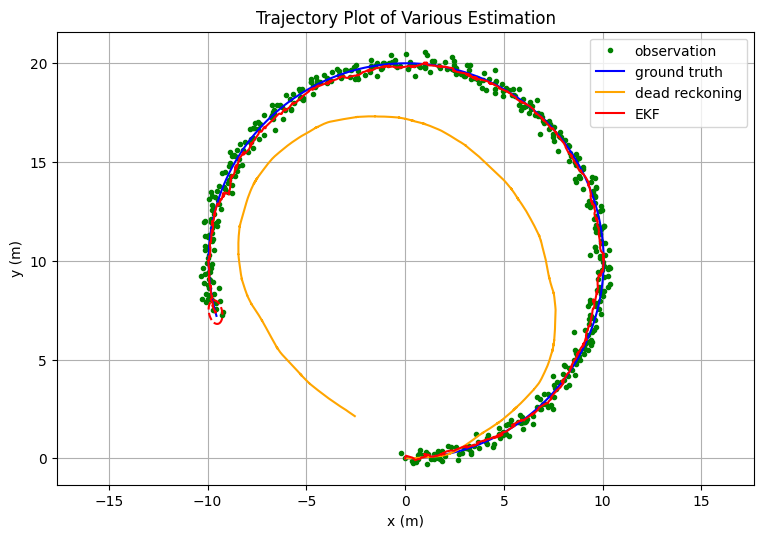

In [25]:
plot_position_2d()